# Ice thickness inversion

This example shows how to run the OGGM ice thickness inversion model
with various ice parameters: the deformation parameter A and a sliding
parameter (fs).

There is currently no "best" set of parameters for the ice thickness
inversion model. As shown in
[Maussion et al. (2019)](https://www.geosci-model-dev.net/12/909/2019/),
the default parameter set results in global volume estimates which are a bit
larger than previous values. For the global estimate of
[Farinotti et al. (2019)](https://www.nature.com/articles/s41561-019-0300-3),
OGGM participated with a deformation parameter A that is 1.5 times larger than the
generally accepted default value.

There is no reason to think that the ice parameters are the same between
neighboring glaciers. There is currently no "good" way to calibrate them,
or at least no generaly accepted one.
We won't discuss the details here, but we provide a script to illustrate
the sensitivity of the model to this choice.

We also demonstrate how to apply a new global task in OGGM, `workflow.calibrate_inversion_from_consensus` to calibrate the A parameter to match the estimate from [Farinotti et al. (2019)](https://www.nature.com/articles/s41561-019-0300-3).

At the end of this tutorial, we show how to distribute the "flowline thickness" to a glacier map.

## Run

In [1]:
# Libs
import geopandas as gpd

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, graphics

# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_Inversion')
cfg.PATHS['working_dir'] = WORKING_DIR

# Here we use multiprocessing because we have many glaciers
cfg.PARAMS['use_multiprocessing'] = True

# Default parameters
# Deformation: from Cuffey and Patterson 2010
glen_a = 2.4e-24
# Sliding: from Oerlemans 1997
fs = 5.7e-20

2023-03-14 08:55:50: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-03-14 08:55:50: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-03-14 08:55:50: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-03-14 08:55:50: oggm.cfg: Multiprocessing switched ON after user settings.


### Read the shapefile 

For the following code to work, you will need to downlad the [hunza_selection](https://github.com/OGGM/training-lahore/raw/main/docs/day_4/hunza_selection.zip) shapefile, extract it on your computer, and upload the files to the classroom directory.

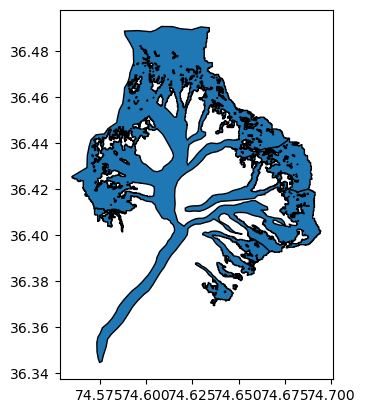

In [2]:
rgi_df = gpd.read_file('hunza_selection.shp')
rgi_df.plot(edgecolor='k');

This is a selection of 17 glaciers from the Hunza basin:

In [3]:
rgi_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-14.03372,G074575E36410N,19990916,-9999999,74.5754,36.4096,14,2,0.198,5691,...,302,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.58061 36.41080, 74.58061 36.40962..."
1,RGI60-14.03373,G074579E36407N,19990916,-9999999,74.5789,36.4072,14,2,0.176,5092,...,638,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.58062 36.40908, 74.58062 36.40836..."
2,RGI60-14.03379,G074583E36408N,19990916,-9999999,74.5826,36.4077,14,2,0.158,4811,...,1143,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.58529 36.41072, 74.58504 36.41072..."
3,RGI60-14.03487,G074641E36385N,19990916,-9999999,74.6405,36.3852,14,2,0.221,4437,...,1031,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.64698 36.38306, 74.64699 36.38198..."
4,RGI60-14.03545,G074637E36376N,19990916,-9999999,74.6370,36.3756,14,2,0.855,3853,...,2378,0,0,0,0,0,9,NaN,WARN:WasInvalid;,"POLYGON ((74.63605 36.37681, 74.63605 36.37708..."
5,RGI60-14.03546,G074648E36377N,19990916,-9999999,74.6480,36.3773,14,2,0.027,5359,...,180,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.64876 36.37793, 74.64809 36.37793..."
6,RGI60-14.03581,G074636E36371N,19990916,-9999999,74.6361,36.3710,14,2,0.036,5395,...,269,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.63934 36.37195, 74.63875 36.37195..."
7,RGI60-14.05429,G074638E36416N,19990916,-9999999,74.6383,36.4157,14,2,5.586,3641,...,2549,0,0,0,0,0,9,NaN,WARN:WasInvalid;,"POLYGON ((74.66791 36.43640, 74.66791 36.43667..."
8,RGI60-14.05430,G074656E36433N,19990916,-9999999,74.6562,36.4328,14,2,0.110,5103,...,575,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.65085 36.43254, 74.65286 36.43339..."
9,RGI60-14.05431,G074652E36431N,19990916,-9999999,74.6522,36.4311,14,2,0.030,5057,...,146,0,0,0,0,0,9,NaN,NaN,"POLYGON ((74.65253 36.43176, 74.65253 36.43149..."


In [4]:
# Go - get the pre-processed glacier directories
# We start at level 3, because we need all data for the inversion
cfg.PARAMS['border'] = 80
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5'
gdirs = workflow.init_glacier_directories(rgi_df, from_prepro_level=3, prepro_base_url=base_url)

2023-03-14 08:55:51: oggm.workflow: init_glacier_directories from prepro level 3 on 17 glaciers.
2023-03-14 08:55:51: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 17 glaciers


## Inversion 

We estimate the ice thickness for all these glaciers testing various values for the Glen's flow parameter A and the sliding parameter fs. For more information about the inversion procedure in OGGM, visit [the documentation](https://docs.oggm.org/en/stable/inversion.html).

In [5]:
with utils.DisableLogger(): 
    
    # We test all these multiplicative factors against default A
    factors = [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 5, 8, 10]

    # Run the inversions tasks with the given factors
    for f in factors:
        print(f'Now computing factor {f}')
        # Without sliding
        suf = '_{:03d}_without_fs'.format(int(f * 10))
        workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs,
                                     glen_a=glen_a*f, fs=0)
        # Store the results of the inversion only
        utils.compile_glacier_statistics(gdirs, filesuffix=suf,
                                         inversion_only=True)

        # With sliding
        suf = '_{:03d}_with_fs'.format(int(f * 10))
        workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs,
                                     glen_a=glen_a*f, fs=fs)
        # Store the results of the inversion only
        utils.compile_glacier_statistics(gdirs, filesuffix=suf,
                                         inversion_only=True)
        
print('Done!')

Now computing factor 0.1
Now computing factor 0.2
Now computing factor 0.5
Now computing factor 0.8
Now computing factor 1
Now computing factor 1.5
Now computing factor 2
Now computing factor 2.5
Now computing factor 3
Now computing factor 5
Now computing factor 8
Now computing factor 10
Done!


## Results

The data are stored as csv files in the working directory. The easiest way to read them is to use [pandas](http://pandas.pydata.org/)!

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import os

Let's read the output of the inversion with the default OGGM parameters first:

In [8]:
df = pd.read_csv(os.path.join(WORKING_DIR, 'glacier_statistics_010_without_fs.csv'), index_col=0)

One way to visualize the output is to plot the volume as a function of area in a log-log plot, illustrating the well known volume-area relationship of mountain glaciers:

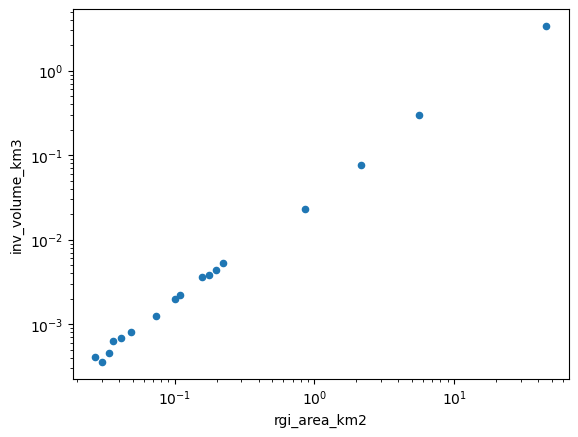

In [9]:
ax = df.plot(kind='scatter', x='rgi_area_km2', y='inv_volume_km3')
ax.semilogx(); ax.semilogy();

As we can see, there is a clear relationship, but it is not perfect. Let's fit a line to these data (the "volume-area scaling law"):

In [10]:
# Fit in log space 
dfl = np.log(df[['inv_volume_km3', 'rgi_area_km2']])
slope, intercept, r_value, p_value, std_err = stats.linregress(dfl.rgi_area_km2.values, dfl.inv_volume_km3.values)

In their paper, [Bahr et al. (1997)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/97JB01696) describe this relationship as:

$$V = \alpha S^{\gamma}$$

With V the volume in km$^3$, S the area in km$^2$ and $\alpha$ and $\gamma$ the scaling parameters (0.034 and 1.375, respectively). How does OGGM compare to these?

In [11]:
print('power: {:.3f}'.format(slope))
print('slope: {:.3f}'.format(np.exp(intercept)))

power: 1.225
slope: 0.032


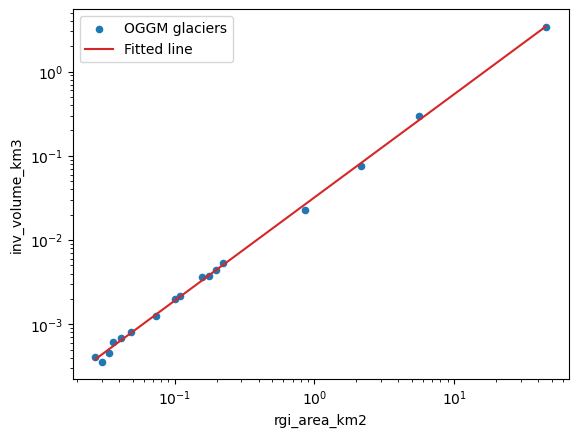

In [12]:
xlim = [df['rgi_area_km2'].min(), df['rgi_area_km2'].max()]
ax = df.plot(kind='scatter', x='rgi_area_km2', y='inv_volume_km3', label='OGGM glaciers')
ax.plot(xlim, np.exp(intercept) * (xlim ** slope), color='C3', label='Fitted line')
ax.semilogx(); ax.semilogy();
ax.legend();

## Sensitivity analysis 

Now, let's read the output files of each run separately, and compute the regional volume out of them:

In [13]:
dftot = pd.DataFrame(index=factors)
for f in factors:
    # Without sliding
    suf = '_{:03d}_without_fs'.format(int(f * 10))
    fpath = os.path.join(WORKING_DIR, 'glacier_statistics{}.csv'.format(suf))
    _df = pd.read_csv(fpath, index_col=0, low_memory=False)
    dftot.loc[f, 'without_sliding'] = _df.inv_volume_km3.sum()
    
    # With sliding
    suf = '_{:03d}_with_fs'.format(int(f * 10))
    fpath = os.path.join(WORKING_DIR, 'glacier_statistics{}.csv'.format(suf))
    _df = pd.read_csv(fpath, index_col=0, low_memory=False)
    dftot.loc[f, 'with_sliding'] = _df.inv_volume_km3.sum()

And plot them:

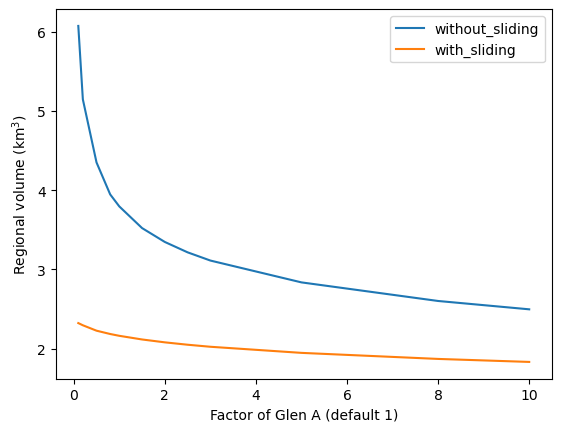

In [14]:
dftot.plot();
plt.xlabel('Factor of Glen A (default 1)'); plt.ylabel('Regional volume (km$^3$)');

As you can see, there is quite a difference between the solutions. In particular, close to the default value for Glen A, the regional estimates are very sensitive to small changes in A. The calibration of A is a problem that has yet to be resolved by global glacier models...

## Calibrate to match an existing volume estimate 

Here, one "best Glen A" is found in order that the total inverted volume of the glaciers of gdirs fits to the estimate from Farinotti et al. (2019).

In [15]:
# when we use all glaciers, no Glen A could be found within the range [0.1,10] that would match the consensus estimate
# usually, this is applied on larger regions where this error should not occur ! 
cdf = workflow.calibrate_inversion_from_consensus(gdirs, filter_inversion_output=False, apply_fs_on_mismatch=True)

2023-03-14 09:02:43: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 17 glaciers
2023-03-14 09:02:43: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2023-03-14 09:02:43: oggm.workflow: Applying global task inversion_tasks on 17 glaciers
2023-03-14 09:02:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 17 glaciers
2023-03-14 09:02:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 17 glaciers
2023-03-14 09:02:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 17 glaciers
2023-03-14 09:02:43: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2023-03-14 09:02:43: oggm.workflow: Applying global task inversion_tasks on 17 glaciers
2023-03-14 09:02:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 17 glaciers
2023-03-14 09:02:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 17 glaciers
2023-03-14 09:02:43: oggm.workf

In [16]:
cdf.sum()

vol_itmix_m3        2.505300e+09
vol_bsl_itmix_m3    0.000000e+00
vol_oggm_m3         2.505365e+09
dtype: float64

Note that here we calibrate the Glen A parameter to a value that is equal for all glaciers of gdirs, i.e. we calibrate to match the total volume of all glaciers and not to match them individually.

*just as a side note, "vol_bsl_itmix_m3" means volume below sea level and is therefore zero for these Alpine glaciers!*

## Distributed ice thickness 

The OGGM inversion and dynamical models use the "1D" flowline assumption: for some applications, you might want to use OGGM to create distributed ice thickness maps. Currently, OGGM implements two ways to "distribute" the flowline thicknesses, but only [the simplest one](https://docs.oggm.org/en/stable/generated/oggm.tasks.distribute_thickness_per_altitude.html) works robustly:

In [20]:
gdir = gdirs[12]

In [17]:
# Distribute
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, [gdir]);

2023-03-14 09:02:46: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 17 glaciers


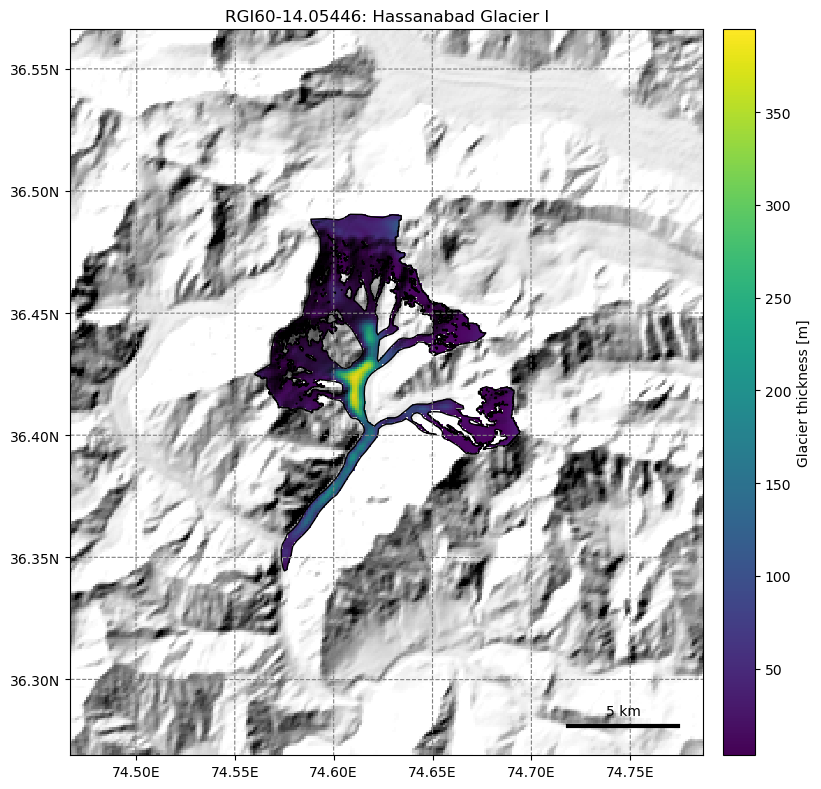

In [21]:
graphics.plot_distributed_thickness(gdir, figsize=(12, 8))